In [240]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2grey,rgb2hsv
from skimage.transform import resize
import math
%matplotlib inline


In [4]:
# paths to our training and test dataset
training_path = 'data/traffic_light_classify/traffic_light_images/training'
test_path = 'data/traffic_light_classify/traffic_light_images/test'

In [6]:
# function that loads the dataset into our notebook
def import_dataset(path):
    image_ls =[]
    image_types= ['red','yellow','green']
    for image_type in image_types:
        file_lists = glob.glob(os.path.join(path, image_type, '*'))
        for file in file_lists:
            im = mpimg.imread(file)
            if not im is None:
                image_ls.append((im, image_type))
    return image_ls

In [8]:
# load our training dataset into a list
image_list = import_dataset(training_path)

len(image_list)

1187

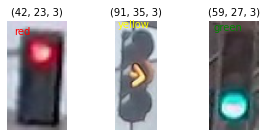

In [48]:
# let's first take a look at what the images look like 
fig,ax = plt.subplots(1,3,figsize=(5,2))

#red
img_red = image_list[0][0] # actual image
plt.imshow(img_red)
ax[0].imshow(img_red)
ax[0].annotate(image_list[0][1], xy=(2,5), color='red', fontsize='10') # annotate the image with its label
ax[0].axis('off')
ax[0].set_title(img_red.shape, fontsize=10) # print the shape of the image (its dimensions)

#yellow
img_yellow = image_list[724][0] # actual image
plt.imshow(img_yellow)
ax[1].imshow(img_yellow)
ax[1].annotate(image_list[724][1], xy=(2,5), color='yellow', fontsize='10') # annotate the image with its label
ax[1].axis('off')
ax[1].set_title(img_yellow.shape, fontsize=10) # print the shape of the image (its dimensions)

#green
img_green = image_list[800][0] # actual image
plt.imshow(img_green)
ax[2].imshow(img_green)
ax[2].annotate(image_list[800][1], xy=(2,5),color='green', fontsize='10') # annotate the image with its label
ax[2].axis('off')
ax[2].set_title(img_green.shape, fontsize=10) # print the shape of the image (its dimensions)

plt.show()


We see that each image is an isolated image of a traffic light, with a label attached to it, denoting the color of that traffic light. Furthermore, we also know the dimensions of the image, given by (x, y, z). 

In [528]:
# From above, we see that each image is of different dimensions so we want to standardize everything. 
def standardize(image_list):
    ls = []
    for item in image_list:
        image = item[0] 
        label = item[1] 
        standardized_im = standardize_image(image) # standardize dimensions of the image
        vector = create_image_vector(label) # relabel image to its corresponding vector
        ls.append((standardized_im, vector)) # append to our standardized image list
    return ls

def standardize_image(image):
    # Resize image to be 32 x 32 x 3
    standardized_image = resize(image, (32, 32))
    return standardized_image

# these labels were chosen arbitrarily, and don't really mean anything. It's just easier to see and compare. 
def create_image_vector(label):
    if label == 'red':
        return [1,0,0]
    elif label == 'yellow':
        return [0,1,0]
    else:
        return [0,0,1]

In [18]:
standardized_train_image_list = standardize(image_list) # standardized image list 

As of now, every image is represented in the RGB color space, ie: Red, Green, and Blue. Each pixel is a mixture of these three colors. For our purposes, we can do much more if it were in the HSV color space, ie: Hue, Saturation, and Value.

Hue is the actual color of the pixel, denoted by a number from 0 - 360 degrees. Or it can be normalized so that it's range is the same as Saturation and Value, namely 0 - 1.

Saturation is how vivid a color is. It can be thought of as how much gray-ness is in the color, denoted by a number between 0 and 1 (0 being gray).

Value is the brightness / intensity of the color, denoted by a number between 0 and 1 (0 being black).


Label:  [0, 0, 1]


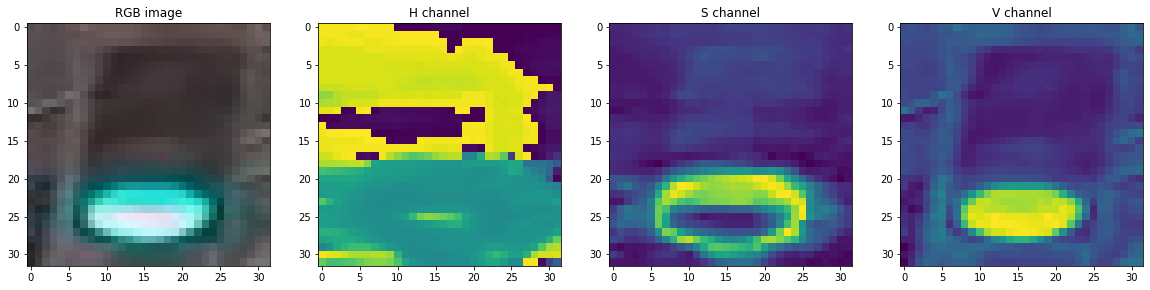

In [513]:
# let's first take a look at what this color space looks like

# take the 800-th image (and its label) in our standardized training dataset
im = standardized_train_image_list[800][0]
label = standardized_train_image_list[800][1]

# convert the image from rgb to hsv
hsv = rgb2hsv(im)
h = hsv[:,:,0] # hue channel
s = hsv[:,:,1] # saturation channel
v = hsv[:,:,2] # value channel

print('Label: ' , str(label)) # print the label of the image


fig,ax = plt.subplots(1,4,figsize=(20,10))

# Plot the original image in rgb and the three channels of hsv
ax[0].set_title('RGB image')
ax[0].imshow(im)
ax[1].set_title('H channel')
ax[1].imshow(h)
ax[2].set_title('S channel')
ax[2].imshow(s)
ax[3].set_title('V channel')
ax[3].imshow(v)

Now that we've preprocessed our dataset, we need to now achieve traffic light classification. I will show you how I achieve this by running one image through the entire process, step-by-step.

In [537]:
# select the 800-th image as our example, and convert it into the hsv color space
hsv_test_image = rgb2hsv(standardized_train_image_list[800][0]) 


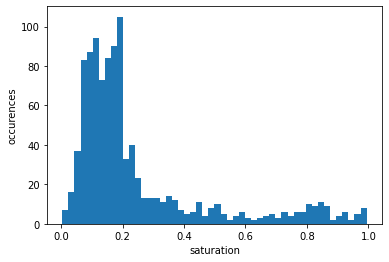

In [554]:
s_val_1d = hsv_test_image[:,:,1].ravel() # compress the array representing the saturation channel into one dimension

# plot a histogram of occurences vs. saturation
plt.hist(s_val_1d,bins=50)
plt.xlabel("saturation")
plt.ylabel("occurences")
plt.show()

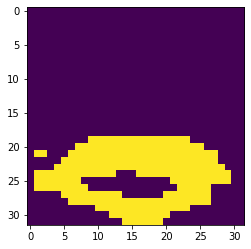

In [560]:
saturation_threshold = 0.3 # from the above graph, choose saturation threshold to be 0.3

idx = hsv_test_image[:, :, 1] <= saturation_threshold # create an array, idx, where indices with value <= 0.3 are True, 
                                                      # and indices with value > 0.3 are false
    
sat_mask = np.ones_like(hsv_test_image[:, :, 1]) # copies the shape of the saturation channel array, 
                                                 # but with all entries as 1
    
sat_mask[idx] = 0 # for the indices in the idx array where value is True, replace with 0

plt.imshow(sat_mask)

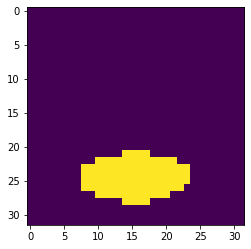

In [591]:
v_thres_val = 0.6 # choose value threshold to be 0.6 (arbitrarily). We could do the same as above and look at a 
                  # histogram, but the point I'm trying to make is that this is a hyper-parameter, and it can be set
                  # as whatever you like. 
        
# perform the same operation as before, but with the array representing the value channel
idx = hsv_test_image[:, :, 2] <= v_thres_val

val_mask = np.ones_like(hsv_test_image[:, :, 2])

val_mask[idx] = 0

plt.imshow(val_mask)

Text(0.5, 1.0, 'mask to be applied')

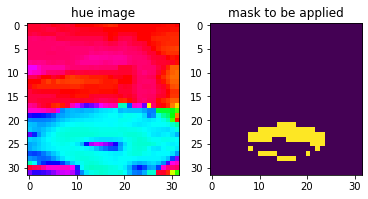

In [603]:
hue_image = hsv_test_image[:,:,0] # array representing the hue channel

fig,ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(hue_image,cmap='hsv') # show the hue channel's image
ax[0].set_title("hue image")

# np.logical_and is a function that takes two arrays with 0's and 1's. And at each index of both arrays, 
# performs the AND logical operator, ie: 1 AND 1 = True, all else = False. 
ax[1].imshow(np.logical_and(sat_mask,val_mask)) 
ax[1].set_title("mask to be applied")

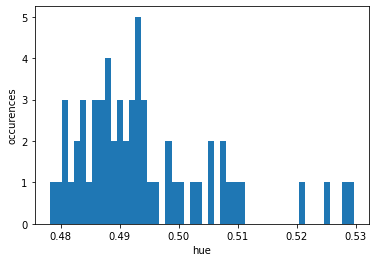

In [605]:
# Apply the AND-ed array to the array representing the hue channel of the image. 
# ie: At each index, if it's True, retain the hue value. If it's False, then delete it. 
# Then, compress the array into 1D so we can graph it. 
hue_1d = hue_image[np.logical_and(val_mask, sat_mask)].ravel() 

# plot a histogram of occurences vs. hue
plt.hist(hue_1d,bins=50)
plt.xlabel("hue")
plt.ylabel("occurences")
plt.show()

We find that for this image, the remaining hue values are all centered at around 0.5, which is close to the mean that we will discover from the training dataset for an image of a traffic light that is green. 

### Functions:

In [594]:
# returns an array of 1's and 0's, with 1's representing the pixels at which the Saturation value is >= the threshold, 
# and 0's representing the pixels at which the Saturation value is < the threshold
def get_sat_mask(hsv_image, s_thres=0.5):
    idx = (hsv_image[:, :, 1].astype(np.float)) < s_thres
    mask = np.ones_like(hsv_image[:, :, 1])
    mask[idx] = 0
    return mask

# returns an array of 1's and 0's, which 1's representing the pixels at which the Value (intensity) value is >= 
# the threshold, and 0's representing the pixels at which the Value value is < the threshold
def get_val_mask(hsv_image, v_thres=0.5):
    idx = (hsv_image[:, :, 2].astype(np.float)) < v_thres
    mask = np.ones_like(hsv_image[:, :, 2])
    mask[idx] = 0
    return mask

In [595]:
# Applies the AND operator to the two arrays of 1's and 0's, creating an array of boolean values. 
# Then creates an array where, for each True boolean value, the corresponding Hue value is retained, and for each 
# False boolean value, the corresponding Hue value is discarded. 
# Finally, return this array of Hue values
def get_masked_hue_values(rgb_image):
    hsv_test_image = rgb2hsv(rgb_image)
    val_mask = get_val_mask(hsv_test_image, v_thres=0.6)
    sat_mask = get_sat_mask(hsv_test_image, s_thres=0.3)
    masked_hue_image = hsv_test_image[:, :, 0] * 100
    masked_hue_1d = masked_hue_image[np.logical_and(val_mask, sat_mask)].ravel()
    return masked_hue_1d


In [596]:
# get the range of hue values that correspond to the given color of the traffic light
def get_range(color, dataset, delta = 17):
    processed = [] 
    
    # for each image in our dataset, get the Hue values of that image, and append the label as well, to denote
    # the color of the image
    for pair in dataset:
        mask = get_masked_hue_values(pair[0])
        processed.append([mask, pair[1]])
    
    means = []
    for image in processed:
        if (image[1] == color): # if the image is of the color that we want
            
            # compute the mean of the Hue values in that image, and append it to our means array
            if (len(image[0]) != 0): 
                image_mean = 0
                for val in image[0]:
                    image_mean += val
                image_mean = image_mean / len(image[0])
                means.append(image_mean)
                
    # Now we compute the mean of the means.
    mean = 0
    for x in means:
        mean += x
    mean = mean / len(means)
    
    mean = math.floor(mean)
    
    # Now we know what the mean Hue value is for an image of a traffic light that is of this color.
    # So in the future, when we start classifying the color of traffic lights, if the given image 
    # has mean Hue value within mean +/- delta (delta being a hyper-parameter that you set), then 
    # we classify it as this color.
    return [mean - delta, mean + delta]

In [597]:
# given the ranges of the Hue values, as well as a list of Hue values representing the image we want to classify, 
# returns the classification of the image
def classify_color_by_range(hue_ls, r_range, y_range, g_range):
    mean = 0 
    # compute the mean of the Hue values
    for item in hue_ls: 
        mean += item
        
    if len(hue_ls) != 0:
        mean = mean / len(hue_ls)
    
    mean = math.floor(mean)
    
    if mean in range(r_range[0], r_range[1]):
        return [1, 0, 0] # classify as red if mean is in red range
    
    if mean in range(y_range[0], y_range[1]):
        return [0, 1, 0] # classify as yellow if mean is in yellow range
     
    if mean in range(g_range[0], g_range[1]):
        return [0, 0, 1] # classify as green if mean is in green range
    
    return [0, 0, 0] # if mean is in none of the ranges, then classification fails, and returns this 


In [598]:
# get the Hue ranges of each traffic light color
r = get_range([1, 0, 0], standardized_train_image_list)
y = get_range([0, 1, 0], standardized_train_image_list)
g = get_range([0, 0, 1], standardized_train_image_list)

print(r, y, g)

[72, 106] [-4, 30] [32, 66]


In [599]:
# driver function for classification
def classify_color(rgb_image):
    hue_1d_deg = get_masked_hue_values(rgb_image) # get's the relevant Hue values of the image of the traffic light
    return classify_color_by_range(hue_1d_deg, r, y, g) # classifies the color of the traffic light by its Hue values

In [600]:
# Example
# The 800-th image is green, as we know previously.
co = classify_color(standardized_train_image_list[800][0])
print(co) # [0, 0, 1] is the vector corresponding to green, yay!

[0, 0, 1]


### Testing

In [609]:
test_ls = import_dataset(test_path)
standardized_test_list = standardize(test_ls)
random.shuffle(standardized_test_list)
 
def get_misclassified_images(test_images,display=False):
    misclassified_images_labels = []
    for image in test_images:
        im = image[0]
        true_label = image[1]
        assert (len(true_label)==3),'This true_label is not the excepted length (3).'
        predicted_label = classify_color(im)
        assert(len(predicted_label)==3),'This predicted_label is not the excepted length (3).'
        if(predicted_label!=true_label):
            misclassified_images_labels.append((im,predicted_label,true_label))
    return misclassified_images_labels

misclassified = get_misclassified_images(standardized_test_list, display=False)
total = len(standardized_test_list)
num_correct = total - len(misclassified)
accuracy = num_correct / total
print('Accuracy: '+ str(accuracy))

red_count = 0
yellow_count = 0
green_count = 0
for x in misclassified:
    if x[2] == [1, 0, 0]:
        red_count += 1
    if x[2] == [0, 1, 0]:
        yellow_count += 1
    else:
        green_count += 1

print("Number of red traffic lights misclassified: ", red_count)
print("Number of yellow traffic lights misclassified: ", yellow_count)
print("Number of green traffic lights misclassified: ", green_count)

Accuracy: 0.8282828282828283
Number of red traffic lights misclassified:  33
Number of yellow traffic lights misclassified:  2
Number of green traffic lights misclassified:  49
